In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

In [2]:
import tensorflow as tf
# tf.compat.v1.disable_eager_execution()  # model fit with multigpu only works in eager mode
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np

from generator import CityScapesGenerator
from model_residual_v2 import create_model
from loss import focal_loss

Using TensorFlow backend.


In [3]:
K.clear_session()

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

with strategy.scope():
    model = create_model((512, 1024, 3), depths=[1, 2, 4, 8], max_drs=[5, 5, 5, 5], depth_multiplier=6, width=64)
    # model = create_model((512, 1024, 3), depths=[0, 4, 8, 3], max_drs=[7, 7, 7, 5], depth_multiplier=8, width=64)
    model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:

In [6]:
epochs = 150
bs = 4

gen_train = CityScapesGenerator('train', dir_ = '../datasets/cityscapes_seg', batch_size=bs)
gen_val = CityScapesGenerator('val', dir_ = '../datasets/cityscapes_seg', batch_size=bs, augment=False)

In [7]:
with strategy.scope():
    lr_schedule = keras.optimizers.schedules.PolynomialDecay(
        0.003, 
        len(gen_train) * epochs, 
        1e-6, 
        0.9,
    )

    model.compile(
        optimizer=keras.optimizers.Adam(lr_schedule),
        loss=focal_loss,
    )

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint('models/model_residual_v2_{epoch:03d}-{val_loss:.4f}.h5', save_weights_only=True)]

model.fit(
    gen_train,
    epochs=epochs,
    validation_data=gen_val,
    callbacks=callbacks,
    initial_epoch=0,
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 744 steps, validate for 125 steps
Epoch 1/150
INFO:tensorflow:batch_all_reduce: 3 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 3 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 3 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 3 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 3 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 3 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max

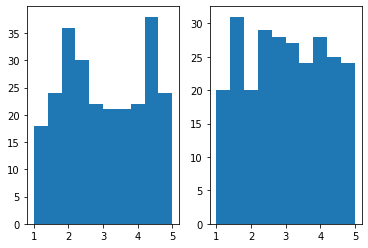

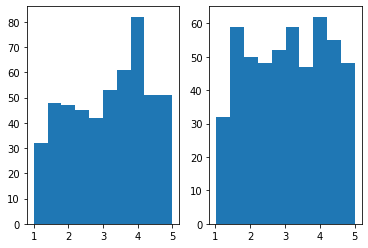

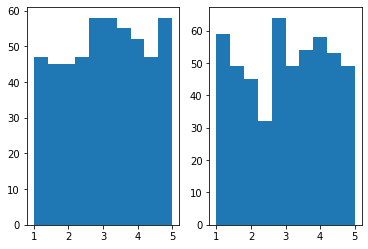

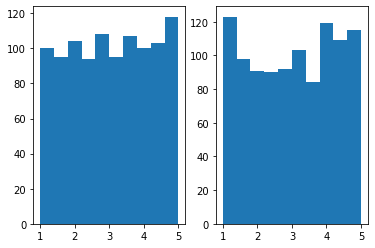

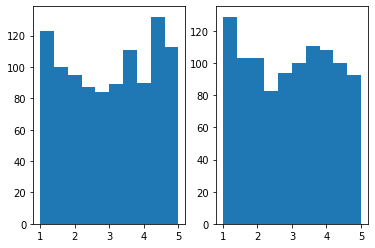

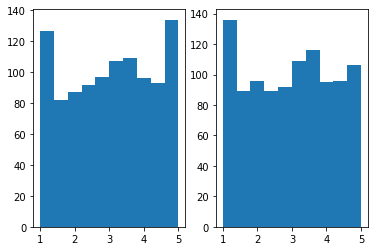

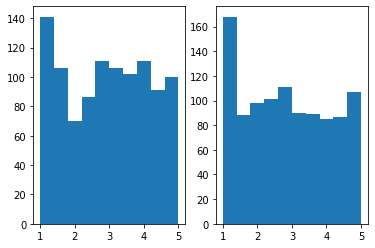

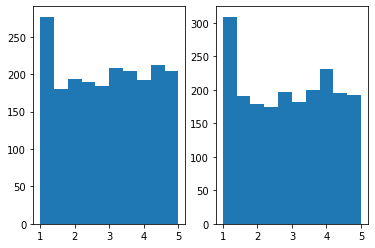

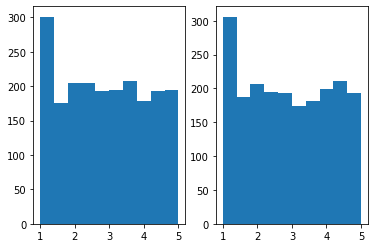

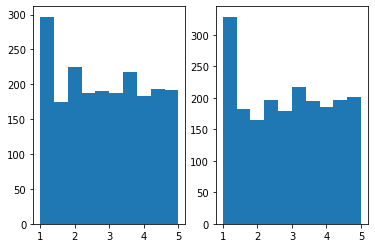

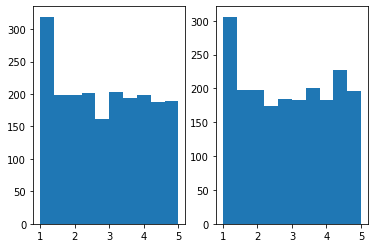

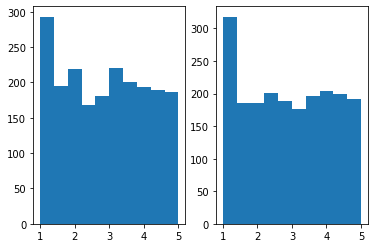

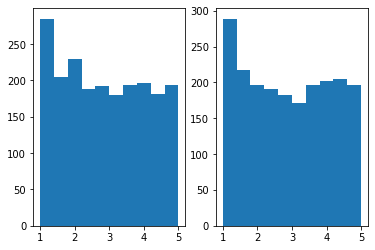

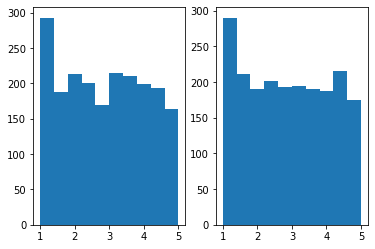

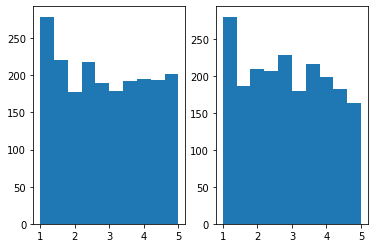

In [10]:
from depthwise_context_conv import DepthwiseContextConv2D

# plot dilation rate histograms
for layer in model.layers:
    if isinstance(layer, DepthwiseContextConv2D):
        weights = layer.get_weights()
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.hist(weights[2].flatten())
        ax2.hist(weights[3].flatten())

In [11]:
import matplotlib.pyplot as plt

pred = model.predict(gen_train[0][0])

plt.imshow(pred[0, ..., 1])
plt.colorbar()

In [ ]:
# TODO: Add SRIP regularization to 1x1 convs. 

In [6]:
bs = 4

gen_train = CityScapesGenerator('train', dir_ = 'data', batch_size=bs)
gen_val = CityScapesGenerator('val', dir_ = 'data', batch_size=bs)

In [5]:
with strategy.scope():
    lr_schedule = keras.optimizers.schedules.PolynomialDecay(
        0.01, 
        len(gen_train) * epochs, 
        1e-5, 
        0.9
    )

    model.compile(
        optimizer=keras.optimizers.Adam(0.01),
        loss=focal_loss,
    )

In [6]:
x, y = gen_train[0]

for lr in np.logspace(-3, 0, 240):
    K.set_value(model.optimizer.lr, lr)
    loss = model.train_on_batch(x, y)
    print(f'{lr:.3g}\t{loss:.3g}')


ValueError: in user code:

    /home/dave/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training_eager.py:309 train_on_batch  *
        outs, total_loss, output_losses, masks = (
    /home/dave/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training_eager.py:278 _process_single_batch  **
        model.optimizer.apply_gradients(zip(grads, trainable_weights))
    /home/dave/.local/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:445 apply_gradients
        self._create_slots(var_list)
    /home/dave/.local/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/adam.py:154 _create_slots
        self.add_slot(var, 'm')
    /home/dave/.local/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:606 add_slot
        .format(strategy, var))

    ValueError: Trying to create optimizer slot variable under the scope for tf.distribute.Strategy (<tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x7fc8cc2519e8>), which is different from the scope used for the original variable (MirroredVariable:{
      0: <tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 64) dtype=float32, numpy=
    array([[[[-0.06227318,  0.09102306, -0.02132092, ..., -0.06551021,
               0.05431031,  0.02428193],
             [-0.04311999, -0.02594195, -0.0847182 , ..., -0.01240116,
              -0.08460464,  0.07259627],
             [-0.0599013 , -0.04453171,  0.00282436, ..., -0.08842891,
               0.09905189,  0.08233505]],
    
            [[ 0.07053714,  0.02978145,  0.07056737, ...,  0.0541418 ,
              -0.0647165 ,  0.06979419],
             [ 0.05408075, -0.09299619,  0.07609117, ..., -0.06253864,
              -0.07234334,  0.02061843],
             [ 0.05617794,  0.0431411 , -0.0954269 , ...,  0.00766391,
              -0.05036624,  0.04276229]],
    
            [[ 0.05129632, -0.05820362, -0.00670537, ..., -0.01741812,
               0.0055412 , -0.00125962],
             [-0.05651851, -0.01685219, -0.03380696, ..., -0.04690019,
              -0.06329896,  0.00334548],
             [ 0.01102204,  0.06288686, -0.00426539, ...,  0.09382924,
               0.04315361,  0.04893796]]],
    
    
           [[[-0.06846483, -0.08245718,  0.04130222, ...,  0.01412622,
              -0.04322194, -0.00322384],
             [ 0.04662707, -0.00673353,  0.08461393, ..., -0.07012979,
              -0.05187605,  0.06154367],
             [-0.00990707, -0.00311196, -0.02667429, ...,  0.09126544,
               0.03820974, -0.06287459]],
    
            [[ 0.00700103, -0.05143976,  0.06837705, ...,  0.08147831,
              -0.03643166, -0.0776783 ],
             [ 0.09340058, -0.07790235, -0.07975851, ...,  0.00957687,
              -0.03764397, -0.03279794],
             [ 0.0989747 , -0.03075348,  0.0680382 , ..., -0.01749353,
              -0.08008891,  0.05443744]],
    
            [[-0.00827392, -0.03747365,  0.05950569, ...,  0.08890077,
               0.06674647,  0.05580214],
             [-0.01350959, -0.03240766,  0.04712063, ...,  0.07866295,
               0.0211798 ,  0.06928301],
             [-0.0201239 , -0.00792786,  0.08630392, ..., -0.05431332,
               0.06754841, -0.08337176]]],
    
    
           [[[-0.09474932, -0.00361898, -0.05461284, ...,  0.09057525,
              -0.09553514,  0.03206667],
             [-0.03651036,  0.00097137,  0.04775286, ..., -0.01176495,
               0.00107433, -0.01329833],
             [-0.09952698,  0.08959341,  0.08089229, ...,  0.08592364,
              -0.01295267,  0.03950278]],
    
            [[-0.0644557 ,  0.03922446, -0.0823195 , ...,  0.0849764 ,
              -0.04697757, -0.00994483],
             [ 0.05458547, -0.07640135,  0.06228459, ..., -0.02124517,
               0.09854773,  0.04637176],
             [-0.08189099, -0.03870137, -0.08845859, ...,  0.09446445,
              -0.04917388,  0.09209724]],
    
            [[-0.01294471,  0.01446329, -0.01539435, ..., -0.08003022,
               0.09051587, -0.07579751],
             [-0.06669646,  0.07146139,  0.05890056, ...,  0.09651652,
               0.05820128,  0.09054491],
             [ 0.07035549, -0.05506825, -0.05222894, ...,  0.01643079,
              -0.08107857,  0.05857852]]]], dtype=float32)>,
      1: <tf.Variable 'conv2d/kernel/replica_1:0' shape=(3, 3, 3, 64) dtype=float32, numpy=
    array([[[[-0.06227318,  0.09102306, -0.02132092, ..., -0.06551021,
               0.05431031,  0.02428193],
             [-0.04311999, -0.02594195, -0.0847182 , ..., -0.01240116,
              -0.08460464,  0.07259627],
             [-0.0599013 , -0.04453171,  0.00282436, ..., -0.08842891,
               0.09905189,  0.08233505]],
    
            [[ 0.07053714,  0.02978145,  0.07056737, ...,  0.0541418 ,
              -0.0647165 ,  0.06979419],
             [ 0.05408075, -0.09299619,  0.07609117, ..., -0.06253864,
              -0.07234334,  0.02061843],
             [ 0.05617794,  0.0431411 , -0.0954269 , ...,  0.00766391,
              -0.05036624,  0.04276229]],
    
            [[ 0.05129632, -0.05820362, -0.00670537, ..., -0.01741812,
               0.0055412 , -0.00125962],
             [-0.05651851, -0.01685219, -0.03380696, ..., -0.04690019,
              -0.06329896,  0.00334548],
             [ 0.01102204,  0.06288686, -0.00426539, ...,  0.09382924,
               0.04315361,  0.04893796]]],
    
    
           [[[-0.06846483, -0.08245718,  0.04130222, ...,  0.01412622,
              -0.04322194, -0.00322384],
             [ 0.04662707, -0.00673353,  0.08461393, ..., -0.07012979,
              -0.05187605,  0.06154367],
             [-0.00990707, -0.00311196, -0.02667429, ...,  0.09126544,
               0.03820974, -0.06287459]],
    
            [[ 0.00700103, -0.05143976,  0.06837705, ...,  0.08147831,
              -0.03643166, -0.0776783 ],
             [ 0.09340058, -0.07790235, -0.07975851, ...,  0.00957687,
              -0.03764397, -0.03279794],
             [ 0.0989747 , -0.03075348,  0.0680382 , ..., -0.01749353,
              -0.08008891,  0.05443744]],
    
            [[-0.00827392, -0.03747365,  0.05950569, ...,  0.08890077,
               0.06674647,  0.05580214],
             [-0.01350959, -0.03240766,  0.04712063, ...,  0.07866295,
               0.0211798 ,  0.06928301],
             [-0.0201239 , -0.00792786,  0.08630392, ..., -0.05431332,
               0.06754841, -0.08337176]]],
    
    
           [[[-0.09474932, -0.00361898, -0.05461284, ...,  0.09057525,
              -0.09553514,  0.03206667],
             [-0.03651036,  0.00097137,  0.04775286, ..., -0.01176495,
               0.00107433, -0.01329833],
             [-0.09952698,  0.08959341,  0.08089229, ...,  0.08592364,
              -0.01295267,  0.03950278]],
    
            [[-0.0644557 ,  0.03922446, -0.0823195 , ...,  0.0849764 ,
              -0.04697757, -0.00994483],
             [ 0.05458547, -0.07640135,  0.06228459, ..., -0.02124517,
               0.09854773,  0.04637176],
             [-0.08189099, -0.03870137, -0.08845859, ...,  0.09446445,
              -0.04917388,  0.09209724]],
    
            [[-0.01294471,  0.01446329, -0.01539435, ..., -0.08003022,
               0.09051587, -0.07579751],
             [-0.06669646,  0.07146139,  0.05890056, ...,  0.09651652,
               0.05820128,  0.09054491],
             [ 0.07035549, -0.05506825, -0.05222894, ...,  0.01643079,
              -0.08107857,  0.05857852]]]], dtype=float32)>
    }). Make sure the slot variables are created under the same strategy scope. This may happen if you're restoring from a checkpoint outside the scope
